In [1]:
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import random

In [2]:
# CSV_TRAIN_LABELS = 'data/labels/train_labels.csv'
# TRAIN_IMAGE_DIR = "data/100k/train"

In [3]:
# df = pd.read_csv(CSV_TRAIN_LABELS)
# car_df = df[df['category'] == 'car']

In [4]:
# car_df.to_csv('data/labels/car_train_labels.csv', index=False)

In [5]:
# CSV_TRAIN_LABELS = 'data/labels/val_labels.csv'
# TRAIN_IMAGE_DIR = "data/100k/train"
# df = pd.read_csv(CSV_TRAIN_LABELS)
# car_df = df[df['category'] == 'car']
# car_df.to_csv('data/labels/car_val_labels.csv', index=False)

In [6]:
# CSV_TRAIN_LABELS = 'data/labels/test_labels.csv'
# TRAIN_IMAGE_DIR = "data/100k/train"
# df = pd.read_csv(CSV_TRAIN_LABELS)
# car_df = df[df['category'] == 'car']
# car_df.to_csv('data/labels/car_test_labels.csv', index=False)

In [7]:
from train_DPM import hyperparams_tuning
from train_DPM import check_accuracy
import numpy as np

In [8]:
df = pd.read_csv('./data/labels/car_train_labels.csv')

images = []
labels = []
i = 0
car_boxes_by_image = {}
for idx, row in df.iterrows():
    i+=1
    img_name = row["image"]
    img_path = f'./data/100k/train/{img_name}.jpg'
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Nema slike")
        continue
    x1, y1, x2, y2 = int(row["x1"]), int(row["y1"]), int(row["x2"]), int(row["y2"])
    crop = img[y1:y2, x1:x2]
    if crop.size == 0 or crop.shape[0] == 0 or crop.shape[1] == 0:
        continue
    crop_resized = cv2.resize(crop, (80, 80))
    images.append(crop_resized)
    labels.append(1)  # car = 1
    # Store car boxes for negative sampling
    if img_name not in car_boxes_by_image:
        car_boxes_by_image[img_name] = []
    car_boxes_by_image[img_name].append((x1, y1, x2, y2))
    if i == 5000: break

i = 0
# Add negative samples (background patches)
num_neg_per_img = 20
for img_name, car_boxes in car_boxes_by_image.items():
    i +=1
    img_path = f'./data/100k/train/{img_name}.jpg'
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue
    h, w = img.shape[:2]
    for _ in range(num_neg_per_img):
        for attempt in range(80):  # Try up to 20 times to find a non-overlapping patch
            x1 = random.randint(0, w-80)
            y1 = random.randint(0, h-80)
            x2 = x1 + 80
            y2 = y1 + 80
            # Check overlap with car boxes
            overlaps = False
            for bx1, by1, bx2, by2 in car_boxes:
                if not (x2 < bx1 or x1 > bx2 or y2 < by1 or y1 > by2):
                    overlaps = True
                    break
            if not overlaps:
                crop = img[y1:y2, x1:x2]
                if crop.size == 0 or crop.shape[0] == 0 or crop.shape[1] == 0:
                    continue
                crop_resized = cv2.resize(crop, (80, 80))
                images.append(crop_resized)
                labels.append(0)  # background = 0
                break
    if i == 5000: break

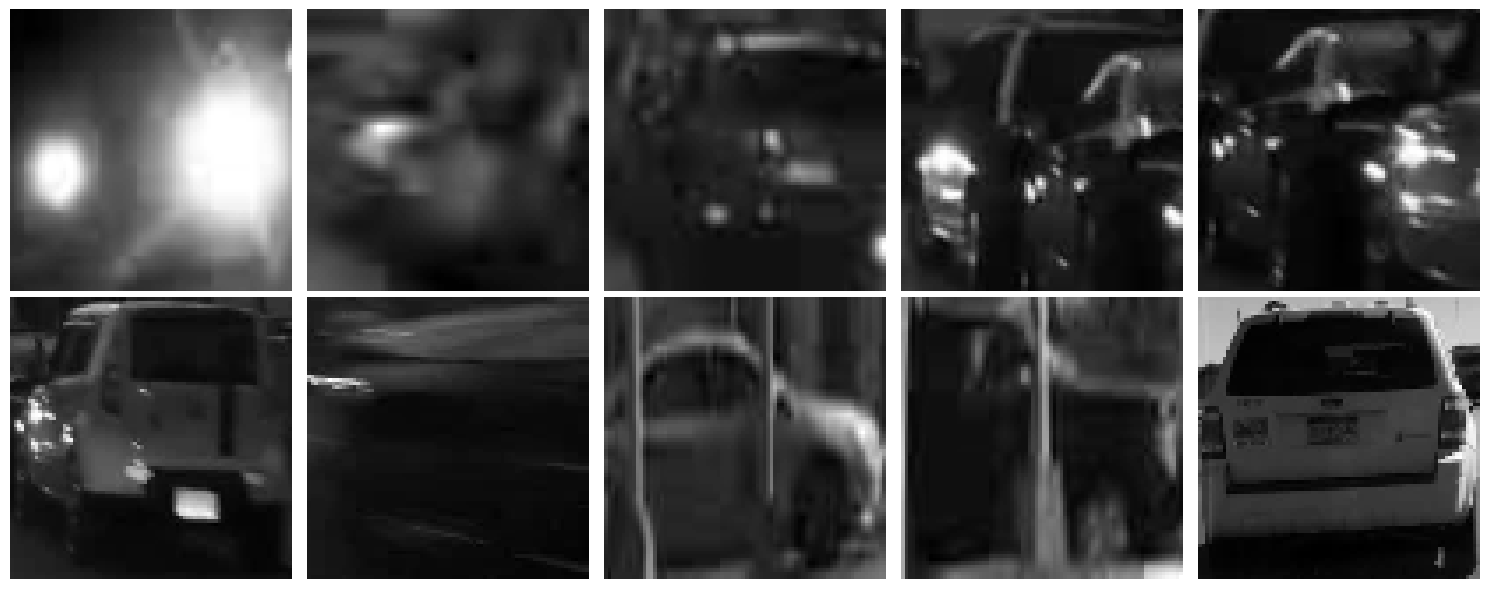

(15418, 80, 80)


In [9]:
data = np.array(images)
labels = np.array(labels).reshape(-1, 1)

plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(data[i], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

img_size = 80
# train data for root filter
print(data.shape)
data_root_filter = data.reshape(-1, img_size, img_size, 1)

# train data for part filters
data_part_filters = [data_root_filter[:,:-1,25:55],
                     data_root_filter[:,25:55,:-1]]

In [10]:
from custom_DPM import DPM
from skimage.feature import hog

In [11]:
# initialize DPM
dpm = DPM()
part_filters = []
# get and save part_filters
for data in data_part_filters:
    part_filter = dpm.compute_part_filters(data)
    part_filters.append(part_filter)

dpm.save_part_filters(part_filters)

c:\Users\marij\M2-UPSACLAY\T6\Computer Vision\cv_object_detection\custom_DPM.py:103: RuntimeWarning: divide by zero encountered in divide
  mag *= 255.0 / np.max(mag)
c:\Users\marij\M2-UPSACLAY\T6\Computer Vision\cv_object_detection\custom_DPM.py:103: RuntimeWarning: invalid value encountered in multiply
  mag *= 255.0 / np.max(mag)


In [12]:
# train root filter 
hog_features = []
for image in data_root_filter:
    fd = hog(image, orientations=dpm.orientations, pixels_per_cell=(dpm.pix_per_cell_root,dpm.pix_per_cell_root),
             cells_per_block=(dpm.cells_per_block_root, dpm.cells_per_block_root), block_norm = 'L2')
    hog_features.append(fd)

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(np.array(hog_features), labels, test_size=0.1, random_state=42)
#hyperparams_tuning(dpm.models["0"],X_train,y_train)

dpm.models["0"].fit(X_train,y_train.ravel())

# check the accuracy
check_accuracy(dpm.models["0"],X_test,y_test)

Accuracy: 0.8884565499351491

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      1019
           1       0.87      0.78      0.83       523

    accuracy                           0.89      1542
   macro avg       0.88      0.86      0.87      1542
weighted avg       0.89      0.89      0.89      1542



In [15]:
# train part filters
for i in range(dpm.parts_count):
    hog_features = []
    for image in data_part_filters[i]:
        fd = hog(image, orientations=dpm.orientations, pixels_per_cell=(dpm.pix_per_cell_part,dpm.pix_per_cell_part),
                cells_per_block=(dpm.cells_per_block_part, dpm.cells_per_block_part), block_norm='L2')
        hog_features.append(fd)

    X_train, X_test, y_train, y_test = train_test_split(np.array(hog_features), labels, test_size=0.1, random_state=42)
    dpm.models[str(i+1)].fit(X_train,y_train.ravel())

    # check the accuracy
    check_accuracy(dpm.models[str(i+1)],X_test,y_test)

dpm.save_clfs()

Accuracy: 0.8612191958495461

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1019
           1       0.82      0.76      0.79       523

    accuracy                           0.86      1542
   macro avg       0.85      0.84      0.84      1542
weighted avg       0.86      0.86      0.86      1542

Accuracy: 0.8553826199740596

              precision    recall  f1-score   support

           0       0.87      0.92      0.89      1019
           1       0.82      0.73      0.77       523

    accuracy                           0.86      1542
   macro avg       0.85      0.83      0.83      1542
weighted avg       0.85      0.86      0.85      1542



# Testing

In [16]:
from test_DPM import get_true_bboxes
import time
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from pprint import pprint

c:\Users\marij\anaconda3\envs\car_env\lib\site-packages\torchmetrics\utilities\imports.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [ ]:
# get ground truth boxes
gr_tr_bboxes = get_true_bboxes('./data/labels/car_test_labels.csv', './data/100k/train')

# get unique image names from the CSV
df_test = pd.read_csv('./data/labels/car_test_labels.csv')
unique_imgs = df_test['image'].unique()[:5]  # limit to 100 images

# initialize DPM
dpm = DPM(mode="eval")
dpm.initialize_part_filters()
os.makedirs('./result', exist_ok=True)
# list of detections
all_detections = []
start_time = time.time()
for i, img_name in enumerate(unique_imgs):
    img_path = f'./data/100k/train/{img_name}.jpg'
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue
    #img = cv2.resize(img, (80, 80))  # adjust size if needed
    cur_detection = dpm.process_image(img, str(i+1))
    all_detections.append(cur_detection)
    print(f"Processed image {i+1}/{len(unique_imgs)}: {img_name}")

# evaluate metric
# evaluate COCO-style mAP@0.5:0.95
metric = MeanAveragePrecision(iou_type="bbox", iou_thresholds=[x/100 for x in range(50, 100, 5)])
metric.update(all_detections, gr_tr_bboxes[:len(all_detections)])
results = metric.compute()
print("mAP@0.5-0.95:", results["map"])
print("mAP@0.5:", results["map_50"])
print("mAP@0.75:", results["map_75"])
print("Per-class AP:", results["map_per_class"])
end_time = time.time()
print("{:.2f} seconds per image".format((end_time-start_time)/len(all_detections)))

Detection:: Location -> (280, 182)
Scale ->  1 | Confidence Score 0.7967479674796748
Width and Height of bounding box -> (79, 30) 

Detection:: Location -> (1162, 224)
Scale ->  1 | Confidence Score 0.7967479674796748
Width and Height of bounding box -> (79, 30) 

Detection:: Location -> (896, 294)
Scale ->  1 | Confidence Score 0.7967479674796748
Width and Height of bounding box -> (79, 30) 

Detection:: Location -> (854, 350)
Scale ->  1 | Confidence Score 0.7967479674796748
Width and Height of bounding box -> (79, 30) 

Detection:: Location -> (924, 350)
Scale ->  1 | Confidence Score 1.0
Width and Height of bounding box -> (30, 79) 

Detection:: Location -> (70, 364)
Scale ->  1 | Confidence Score 1.0
Width and Height of bounding box -> (79, 30) 

Detection:: Location -> (126, 364)
Scale ->  1 | Confidence Score 1.0
Width and Height of bounding box -> (79, 30) 

Detection:: Location -> (406, 364)
Scale ->  1 | Confidence Score 1.0
Width and Height of bounding box -> (30, 79) 

Dete